# **Imports**

In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.cluster import KMeans, DBSCAN

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_iris, load_digits, load_breast_cancer

from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, rand_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

plt.style.use('Solarize_Light2')

# **Functions**

## ***Normalization***

In [2]:
def normalization(model, data) -> pd.DataFrame:
    # apply normalization techniques
    norm = model.transform(data)
    return pd.DataFrame(data=norm, columns=data.columns)

## ***Map Clusters***

In [3]:
def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return labels

In [4]:
def reorder_confusion_matrix(cm):
    # Hungarian algorithm minimizes cost, so we negate to maximize diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Reorder columns based on optimal assignment
    reordered_cm = cm[:, col_ind]
    return reordered_cm

## ***Confusion Matrix***

In [5]:
def heatmap(cm_k_means, cm_db_scan, k):
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Width increases for better spacing

    # First subplot: K-Means
    sns.heatmap(cm_k_means, annot=True, fmt='d', cmap='RdPu', ax=axes[0])
    axes[0].set_xlabel('Predicted Cluster')
    axes[0].set_ylabel('True Cluster')
    axes[0].set_title('K-Means')

    # Second subplot: DBScan
    sns.heatmap(cm_db_scan[:k + 1, :], annot=True, fmt='d', cmap='RdPu', ax=axes[1])
    axes[1].set_xlabel('Predicted Cluster')
    axes[1].set_ylabel('True Cluster')
    axes[1].set_title('DB-Scan')

    plt.tight_layout()
    plt.show()

In [6]:
def confusion_matrix_heatmap(k_means_preds, y_true, db_scan_preds, y_true_db_scan, k):
  # Build confusion matrix
  cm_k_means = confusion_matrix(y_true, k_means_preds)
  cm_db_scan = confusion_matrix(y_true_db_scan, db_scan_preds)

  heatmap(cm_k_means, cm_db_scan, k)

  return (cm_k_means, cm_db_scan)

## ***Metrics***

In [7]:
def calculate_accuracy(confusion_matrix) -> float:
    """
    Calculate accuracy from the confusion matrix.
    Accuracy is the ratio of correct predictions to total samples.

    Args:
    confusion_matrix (np.array): The confusion matrix.

    Returns:
    float: Accuracy value.
    """
    # Total correct predictions are the sum of the diagonal elements
    correct_predictions = np.trace(confusion_matrix)

    # Total samples is the sum of all elements in the confusion matrix
    total_samples = np.sum(confusion_matrix)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    return accuracy

### Cal and Show

In [8]:
def cal_f1_score(confusion_mat):
    prf1 = []
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        col_sum = np.sum(cm[:, i])

        if row_sum == 0 or col_sum == 0:
            prf1.append([0, 0, 0])
            continue

        recall = cm[i, i] / row_sum
        precision = cm[i, i] / col_sum

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * recall * precision / (precision + recall)

        prf1.append(np.array([precision, recall, f1]))

    return np.array(prf1)

In [9]:
def metrics_table(method_name, prf_array, accuracy, w_precision, w_recall, w_f1):
    rows = []

    for i, (p, r, f1) in enumerate(prf_array):
        rows.append([method_name, i, f"{p:.2f}", f"{r:.2f}", f"{f1:.2f}", ""])

    # Summary row with weighted metrics
    rows.append([
        method_name, "Overall",
        f"{w_precision:.3f}", f"{w_recall:.3f}", f"{w_f1:.3f}", f"{accuracy:.2%}"
    ])

    print(tabulate(
        rows,
        headers=["Method", "Cluster", "Precision", "Recall", "F1 Score", "Accuracy"],
        tablefmt="grid"
    ))

In [10]:
def calculate_metrics(cm_kmeans, cm_dbscan):
    # Accuracy
    acc_kmeans = calculate_accuracy(cm_kmeans)
    acc_dbscan = calculate_accuracy(cm_dbscan)

    # Precision, recall, F1
    prf_kmeans = np.array(cal_f1_score(cm_kmeans))
    prf_dbscan = np.array(cal_f1_score(cm_dbscan))

    # Weighted Precision, recall, F1
    weights_k = np.sum(cm_kmeans, axis=1)
    weights_d = np.sum(cm_dbscan, axis=1)

    # Weighted Precision, Recall, F1 for K-Means
    wp_k = np.sum(prf_kmeans[:, 0] * weights_k) / np.sum(weights_k)
    wr_k = np.sum(prf_kmeans[:, 1] * weights_k) / np.sum(weights_k)
    wf1_k = np.sum(prf_kmeans[:, 2] * weights_k) / np.sum(weights_k)

    # Weighted Precision, Recall, F1 for DBSCAN
    wp_d = np.sum(prf_dbscan[:, 0] * weights_d) / np.sum(weights_d)
    wr_d = np.sum(prf_dbscan[:, 1] * weights_d) / np.sum(weights_d)
    wf1_d = np.sum(prf_dbscan[:, 2] * weights_d) / np.sum(weights_d)

    metrics_table("K-Means", prf_kmeans, acc_kmeans, wp_k, wr_k, wf1_k)
    print("\n\n")
    metrics_table("DBSCAN", prf_dbscan, acc_dbscan, wp_d, wr_d, wf1_d)

In [11]:
def calculate_clustering_metrics(method_name, X_valid, labels_valid):
    unique_labels = set(labels_valid)

    # Can't compute metrics with 1 or 0 clusters
    if len(unique_labels) <= 1:
        print(f"\nClustering Evaluation Metrics ({method_name}):")
        print("Not enough clusters to calculate metrics (need at least 2).")
        return

    try:
        silhouette = silhouette_score(X_valid, labels_valid)
    except Exception as e:
        silhouette = None
        print(f"Silhouette Score error: {e}")

    try:
        db_index = davies_bouldin_score(X_valid, labels_valid)
    except Exception as e:
        db_index = None
        print(f"Davies–Bouldin Index error: {e}")

    try:
        ch_index = calinski_harabasz_score(X_valid, labels_valid)
    except Exception as e:
        ch_index = None
        print(f"Calinski–Harabasz Index error: {e}")

    print(f"\nClustering Evaluation Metrics ({method_name}):")
    print(f"Silhouette Score(H)        : {silhouette:.4f}" if silhouette is not None else "Silhouette Score        : N/A")
    print(f"Davies–Bouldin Index(L)    : {db_index:.4f}" if db_index is not None else "Davies–Bouldin Index    : N/A")
    print(f"Calinski–Harabasz Index(H) : {ch_index:.4f}" if ch_index is not None else "Calinski–Harabasz Index : N/A")


# **Main Clustering**

In [12]:
def main(X: pd.DataFrame, y_true: np.array, k: int, eps: float, scalar_model):
    # Normalize X
    scalar = scalar_model().fit(X)
    X_norm = normalization(scalar, X)

    # Perform KMeans and DBScan clustering
    kmeans = KMeans(n_clusters=k)
    y_pred_k_means = kmeans.fit_predict(X_norm)

    dbscan = DBSCAN(eps=eps)
    y_pred_db_scan = dbscan.fit_predict(X_norm)

    # new versions of y_preds
    k_means_labels = map_clusters_to_labels(y_true, y_pred_k_means)

    # remove noises
    dbscan_core_pred = y_pred_db_scan[y_pred_db_scan != -1]
    dbscan_core_true = y_true[y_pred_db_scan != -1]

    db_scan_labels = map_clusters_to_labels(dbscan_core_true, dbscan_core_pred)

    # map clusters and create confusion matrix
    _ = confusion_matrix_heatmap(y_pred_k_means, y_true, y_pred_db_scan, y_true, k)
    cm_k_means, cm_db_scan = confusion_matrix_heatmap(k_means_labels, y_true, db_scan_labels, dbscan_core_true, k)

    calculate_metrics(cm_k_means, cm_db_scan)

    calculate_clustering_metrics("K-Means", X_norm.copy(), y_pred_k_means)
    calculate_clustering_metrics("DBSCAN", X_norm[y_pred_db_scan != -1].copy(), dbscan_core_pred)

# **Main Classification**

In [13]:
def classification_report_helper(y_test, y_pred, y_train, y_pred_train, model_name) -> None:
    print(f"{'=' * 30} {model_name} {'=' * 30}")
    print("test\n", classification_report(y_true=y_test, y_pred=y_pred))
    print("train\n", classification_report(y_true=y_train, y_pred=y_pred_train))


# naive_bayes, KNN, Decision Tree
def main_classifications(data, target, models, scalar_model, data_name) -> None:
    # split train and test
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33)

    # normalize train and test
    scalar = scalar_model().fit(X_train)
    X_train = normalization(scalar, data=X_train)
    X_test = normalization(scalar, data=X_test)

    # perform classification
    for i in range(len(models)):
        models[i][0].fit(X_train, y_train)
        y_pred = models[i][0].predict(X_test)
        y_pred_train = models[i][0].predict(X_train)
        classification_report_helper(y_test, y_pred, y_train, y_pred_train, models[i][1])

    fig, ax = plt.subplots(figsize=(16, 6))
    plot_tree(decision_tree=models[-1][0],
              max_depth=2,
              feature_names=X_train.columns,
              filled=True,
              rounded=True,
              fontsize=10,
              ax=ax)
    plt.title(f"{data_name} Decision Tree")
    plt.tight_layout()
    plt.show()

# **Load Datasets**

In [14]:
X_iris, y_iris = load_iris(return_X_y=True, as_frame=True)
X_bc, y_bc = load_breast_cancer(return_X_y=True, as_frame=True)
X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)

# **Correlations**
In clustering and classification, dropping columns depends on:

    Redundancy (high correlation between features)
    Action: Drop one of the correlated features or use dimensionality reduction

    Irrelevance (low correlation with the label or no clear value added)
    Action: Use feature selection techniques to identify and drop these.

    Low Variance
    
    Domain Knowledge


## Iris

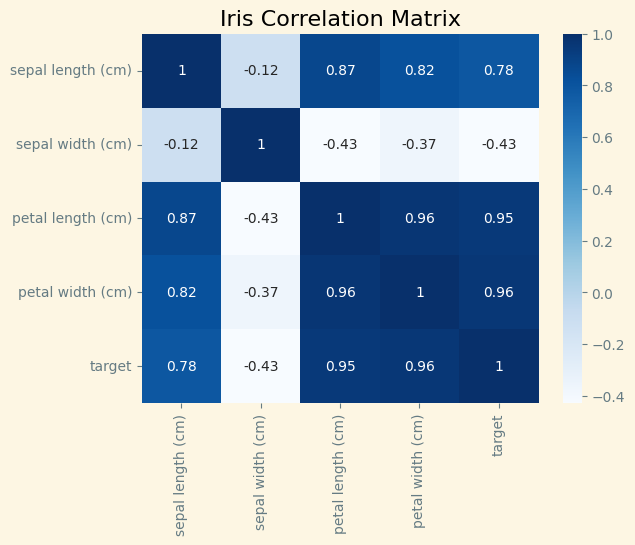

In [15]:
corr_matrix = pd.concat([X_iris, y_iris], axis=1).corr()

sns.heatmap(data=corr_matrix, annot=True, cmap="Blues")
plt.title("Iris Correlation Matrix")
plt.show()

# "sepal width (cm)", "pental length (cm)"

## Breast Cancer

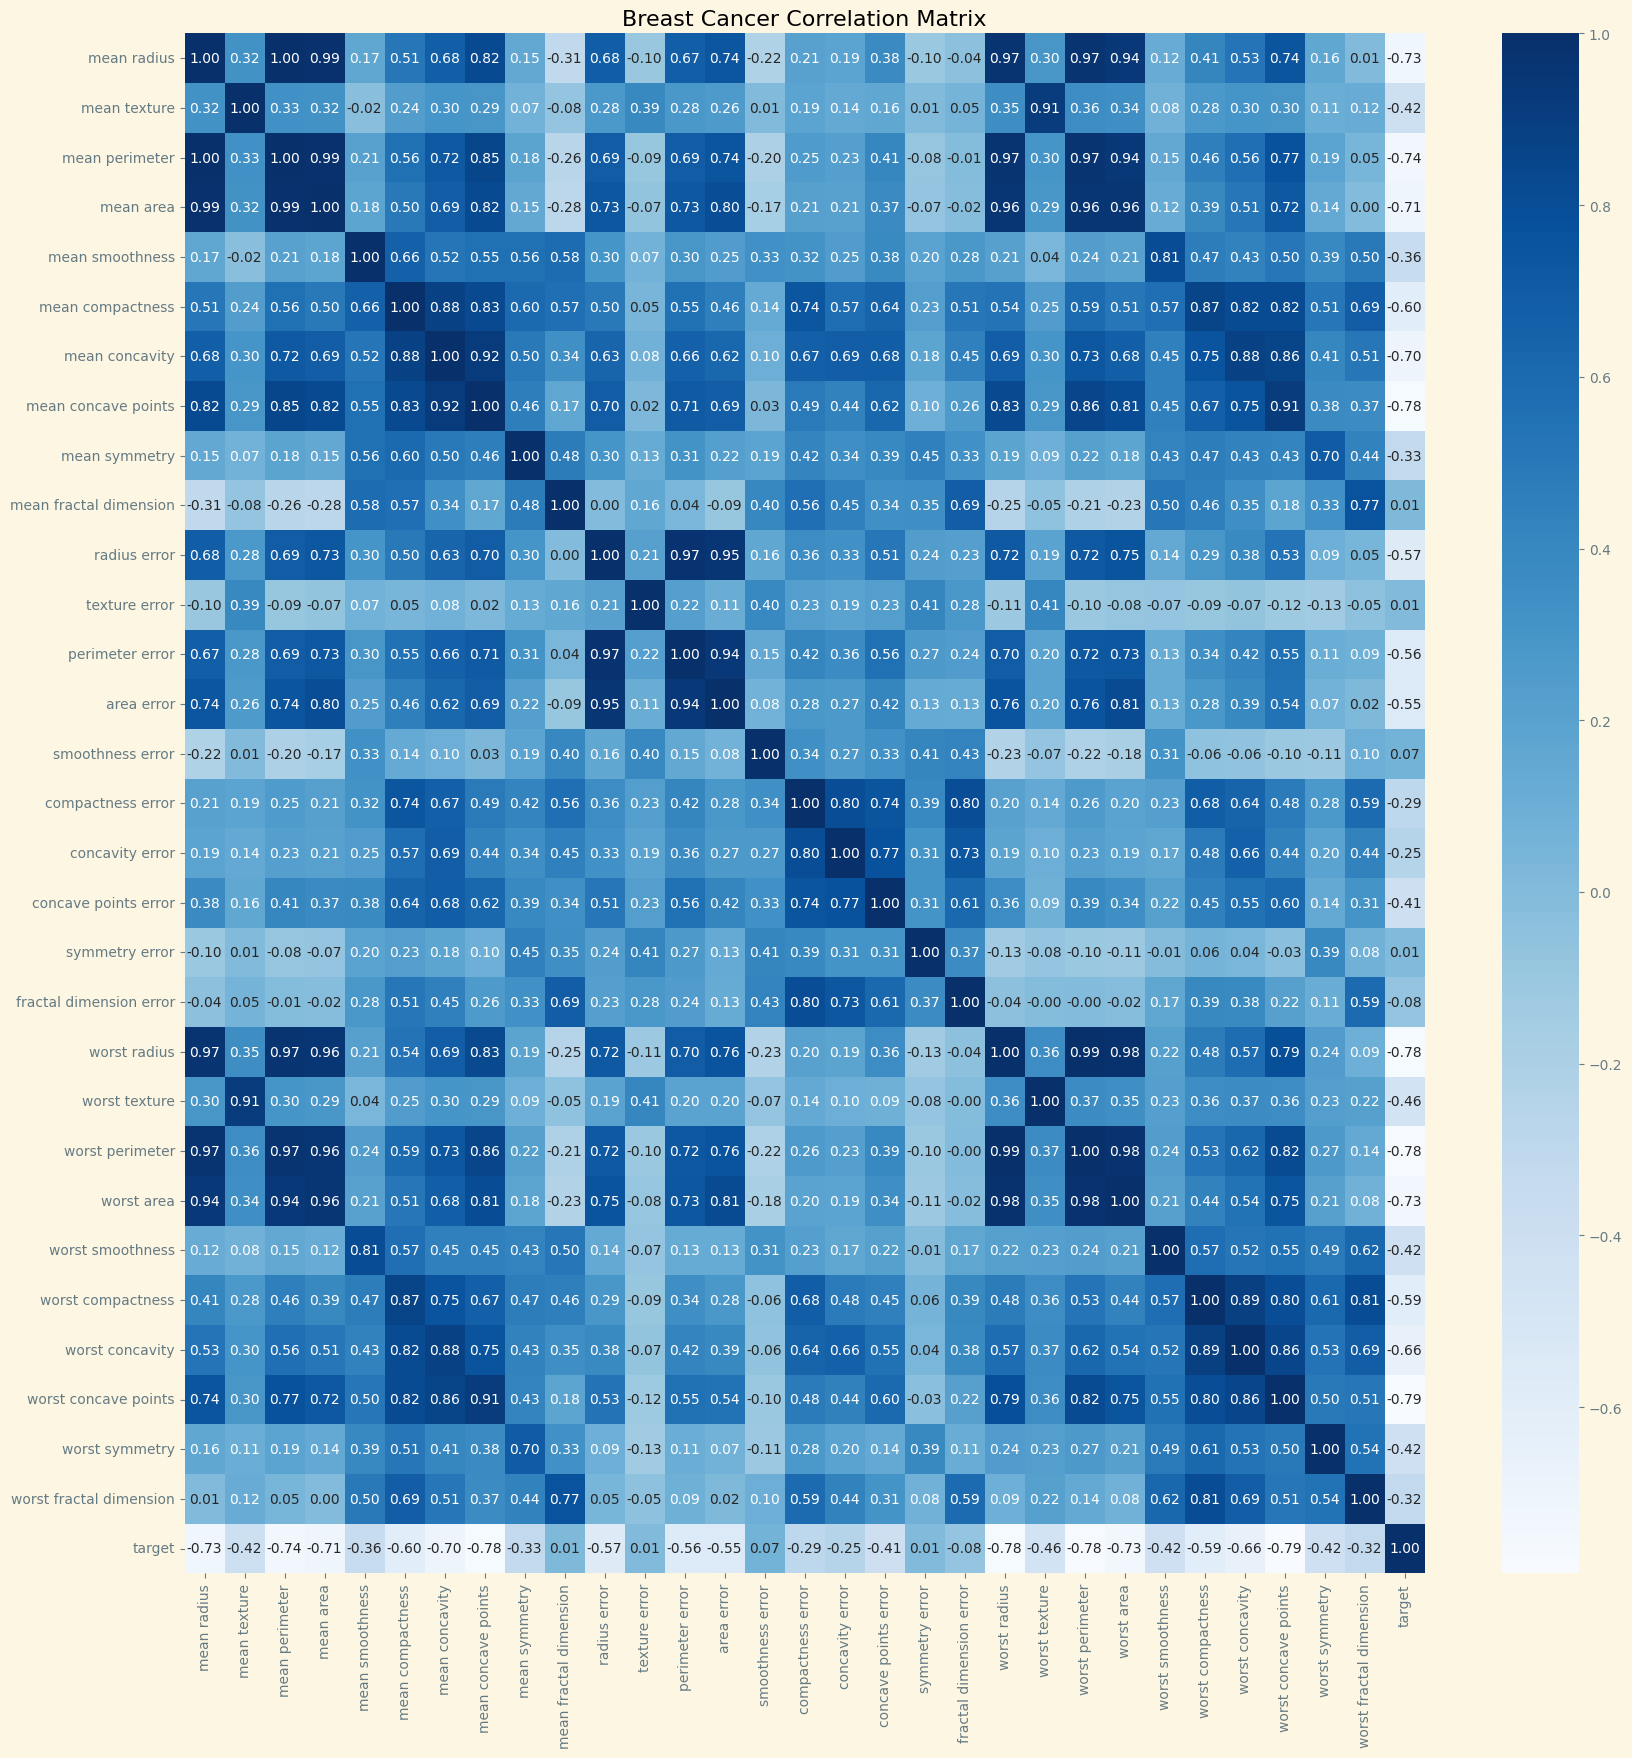

In [16]:
corr_matrix_bc = pd.concat([X_bc, y_bc], axis=1).corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr_matrix_bc, annot=True, cmap="Blues", fmt=".2f")
plt.title("Breast Cancer Correlation Matrix")
plt.show()

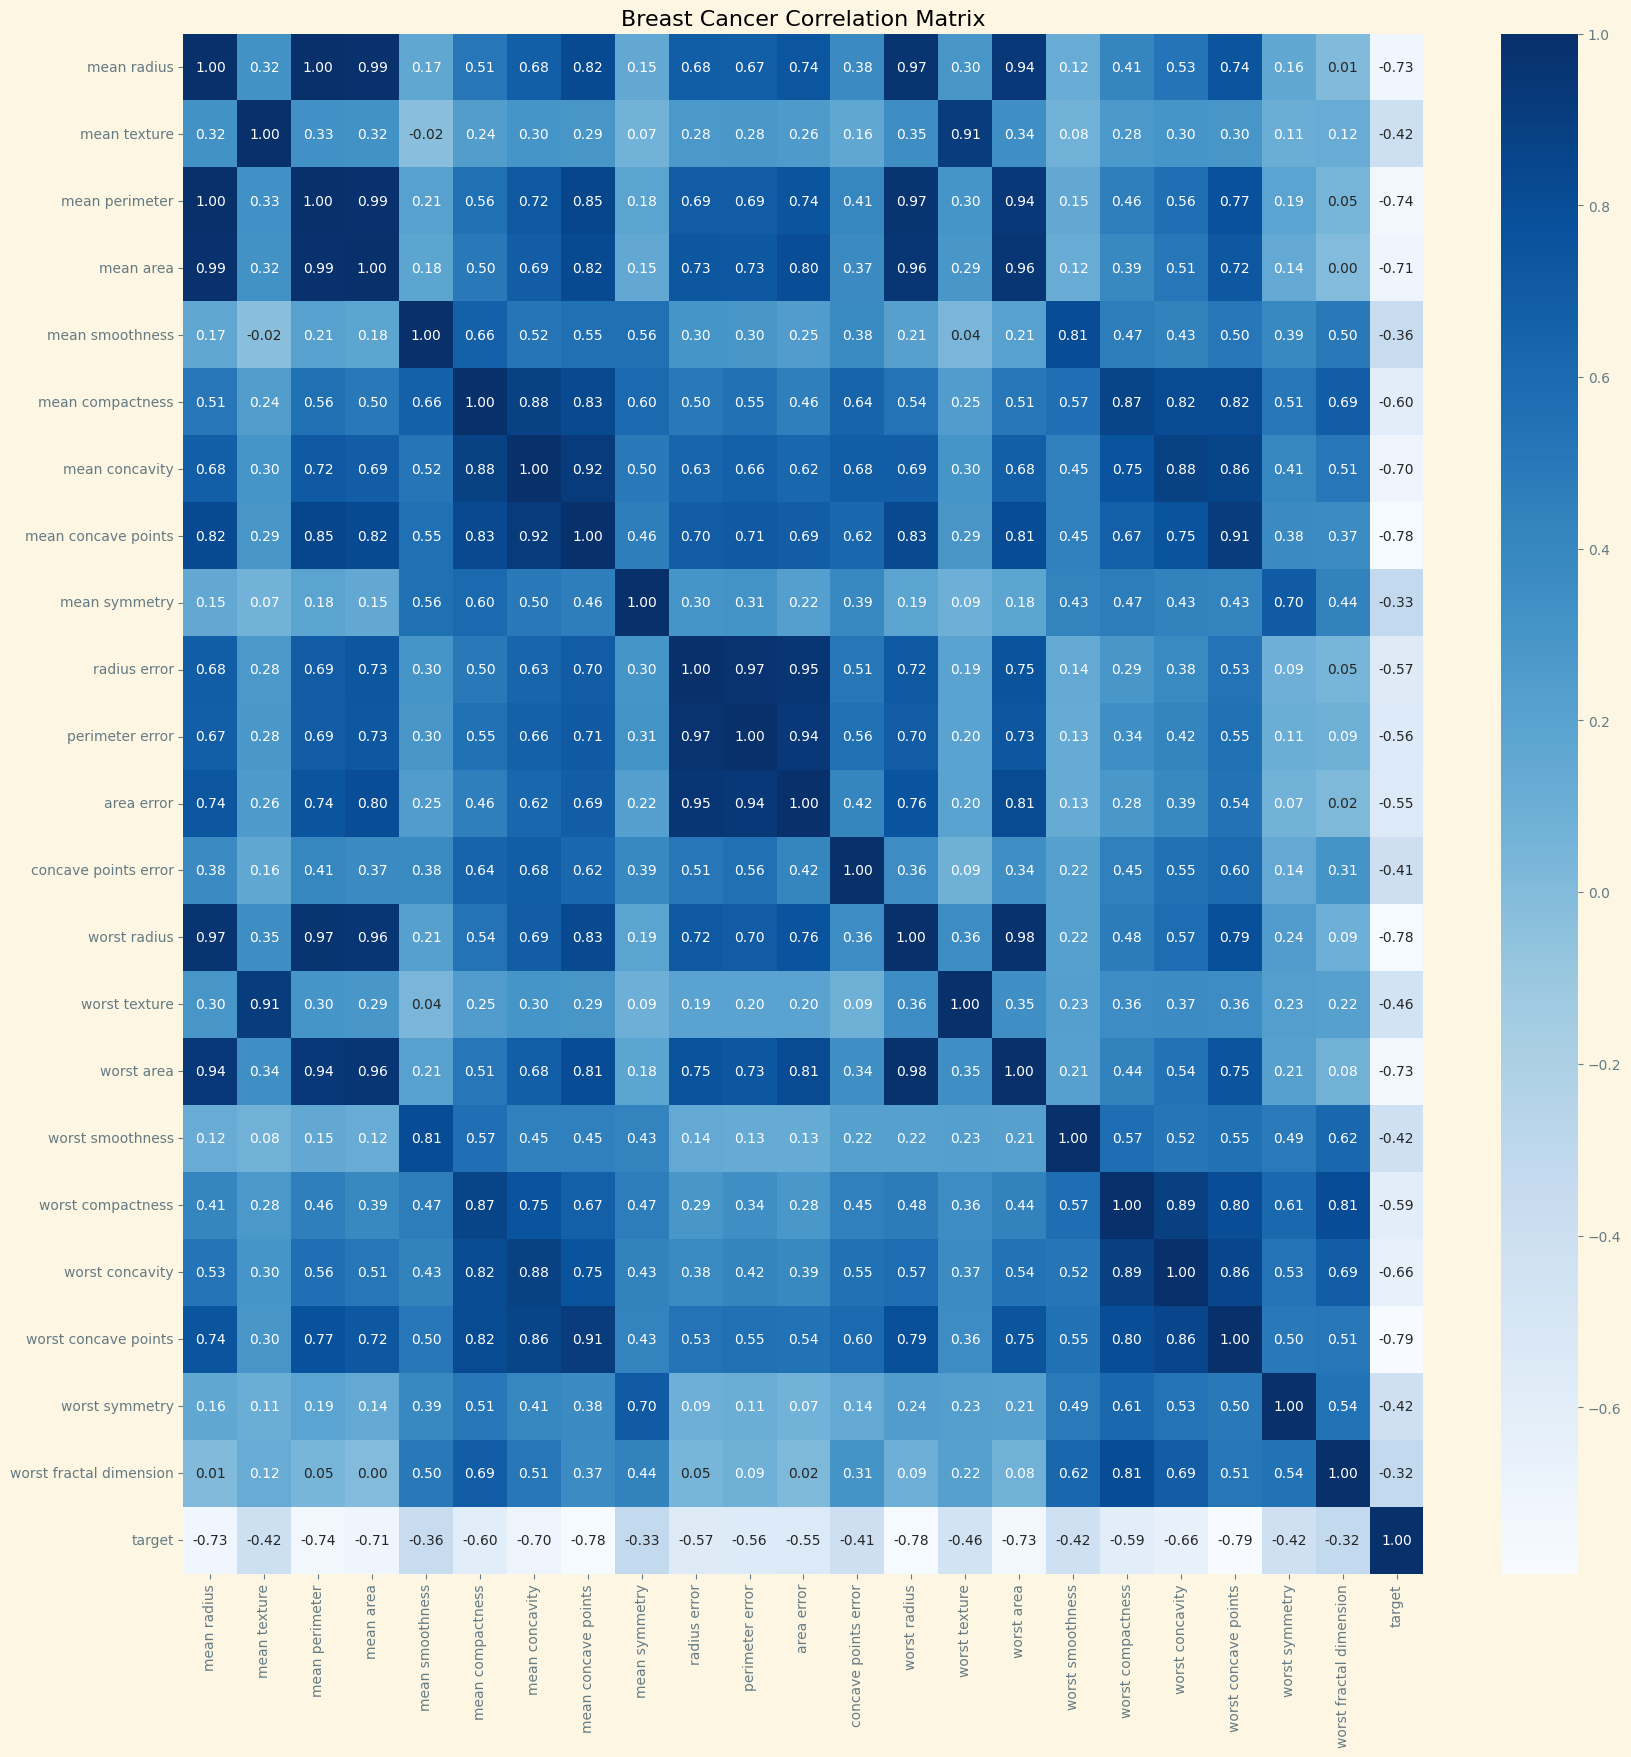

In [17]:
dropable_cols_bc = [9, 11, 14, 15, 16, 18, 19, 22]
corr_matrix_bc = pd.concat([X_bc, y_bc], axis=1).drop(X_bc.columns[dropable_cols_bc], axis=1).corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr_matrix_bc, annot=True, cmap="Blues", fmt=".2f")
plt.title("Breast Cancer Correlation Matrix")
plt.show()

# **Run Main Clustering**

>Silhouette → Range: [-1, 1] Higher is better
   >* A value close to +1: Samples are well-matched to their cluster and poorly matched to neighboring clusters.


>Davies–Bouldin → Range: [0, ∞) Lower is better
   >* Lower values mean clusters are compact and well-separated.


>Calinski–Harabasz → Range: [0, ∞) Higher is better
   >* Higher values indicate well-defined clusters.
   >* Very sensitive to number of clusters and sample size.

## Iris

### All Columns

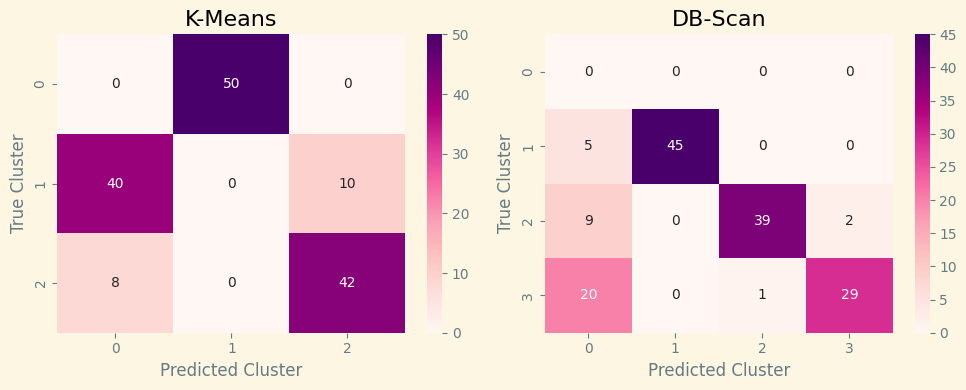

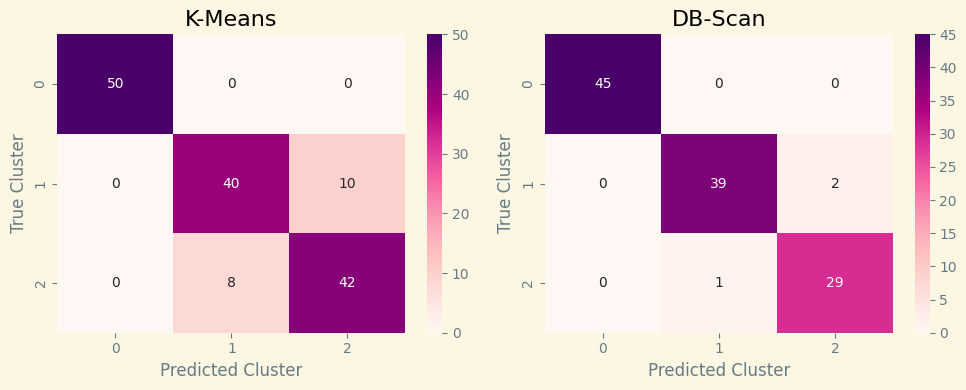

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |        1    |     1    |       1    |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |        0.83 |     0.8  |       0.82 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |        0.81 |     0.84 |       0.82 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |        0.88 |     0.88 |       0.88 | 88.00%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+========

In [18]:
main(X=X_iris.copy(), y_true=y_iris.to_numpy(), k=len(np.unique(y_iris)), eps=0.128, scalar_model=MinMaxScaler)

### Selected Columns

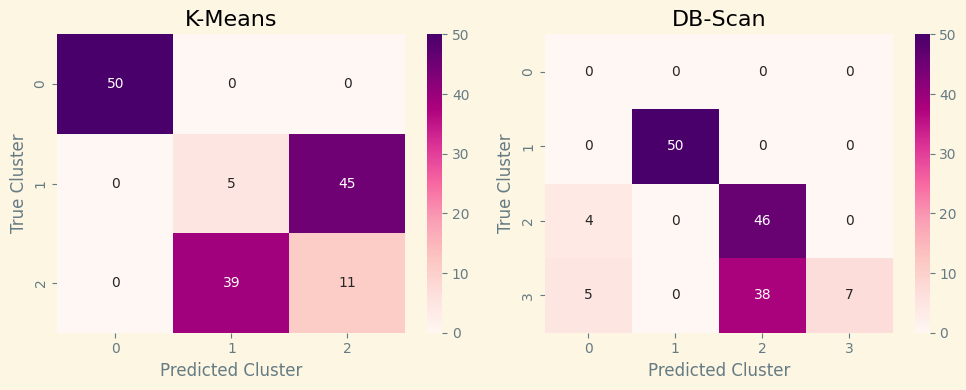

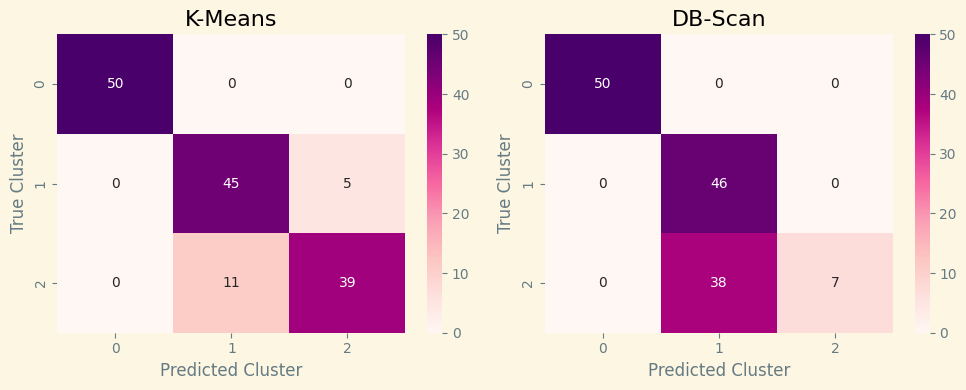

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       1     |    1     |      1     |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.8   |    0.9   |      0.85  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.89  |    0.78  |      0.83  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.897 |    0.893 |      0.893 | 89.33%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+========

In [19]:
main(X=X_iris.iloc[:, [0, 3]].copy(), y_true=y_iris.to_numpy(), k=len(np.unique(y_iris)), eps=0.1, scalar_model=MinMaxScaler)

## Breast Cancer

### All Columns

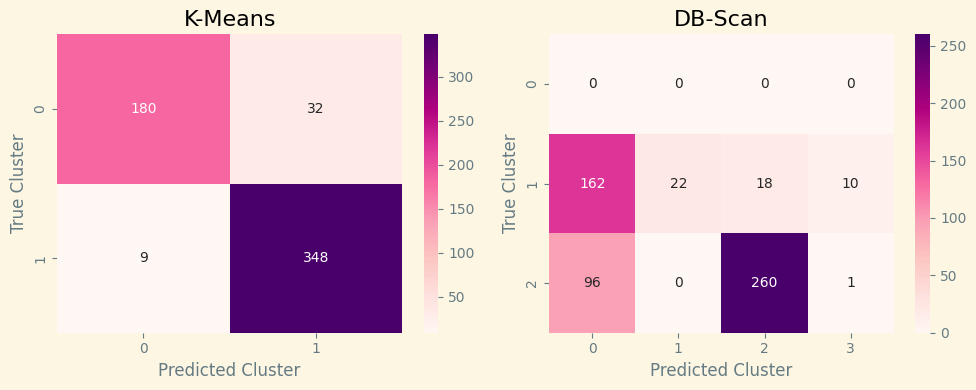

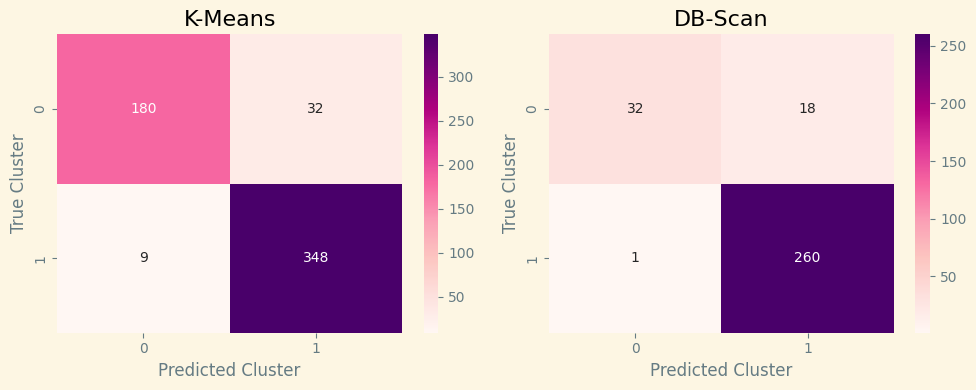

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.95  |    0.85  |      0.9   |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.92  |    0.97  |      0.94  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.929 |    0.928 |      0.927 | 92.79%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| DBSCAN   | 0         |       0.97  |    0.64  |      0.77  |            |
+--------

In [20]:
main(X=X_bc.copy(), y_true=y_bc.to_numpy(), k=len(np.unique(y_bc)), eps=0.325, scalar_model=MinMaxScaler)

It could be overfitting or misleading if:

    You tuned DBSCAN’s parameters (eps, min_samples) based on label performance, which breaks the unsupervised principle and leads to overfitting to the labels.

    DBSCAN found many tiny or noisy clusters that perfectly matched some small parts of the labeled data — this might look good but doesn’t generalize.

    Some clusters may correspond to very few samples, which artificially boosts metrics.

### Selected Columns

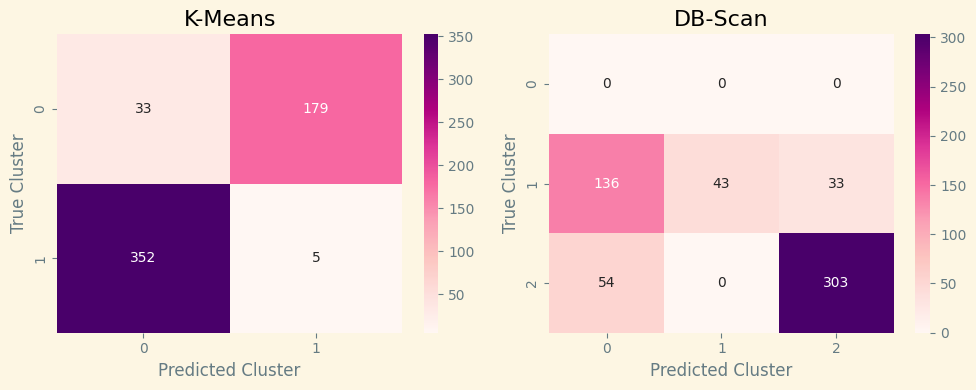

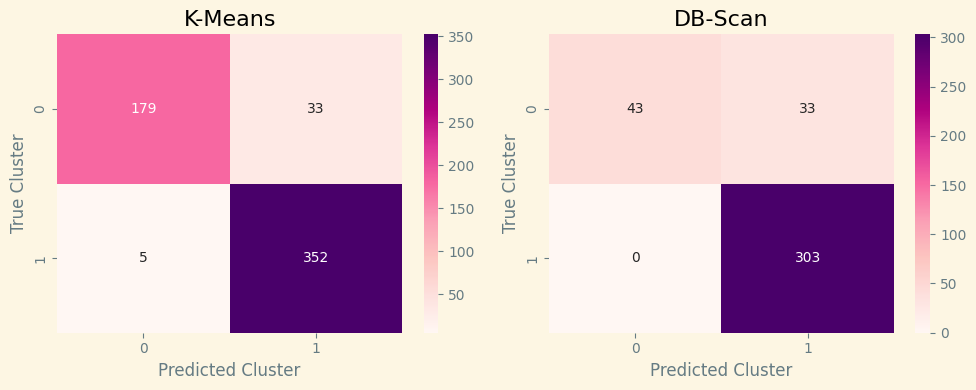

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.97  |    0.84  |      0.9   |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.91  |    0.99  |      0.95  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.936 |    0.933 |      0.932 | 93.32%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| DBSCAN   | 0         |       1     |    0.57  |      0.72  |            |
+--------

In [21]:
main(X=X_bc.drop(X_bc.columns[dropable_cols_bc], axis=1).copy(), y_true=y_bc.to_numpy(), k=len(np.unique(y_bc)), eps=0.3, scalar_model=MinMaxScaler)

## Digits

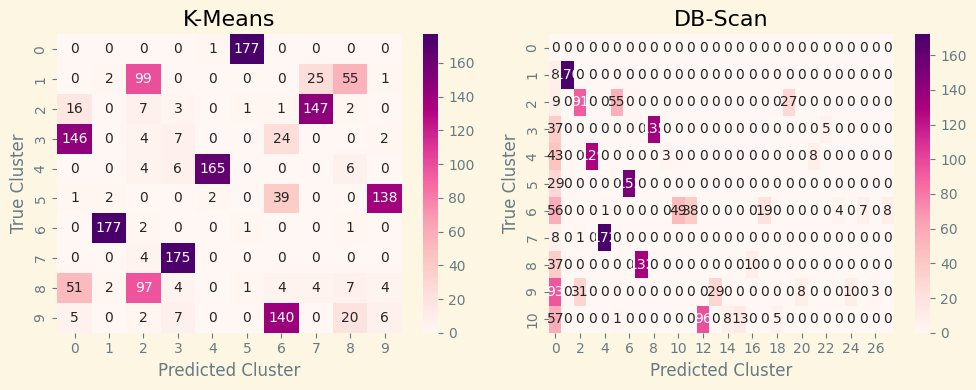

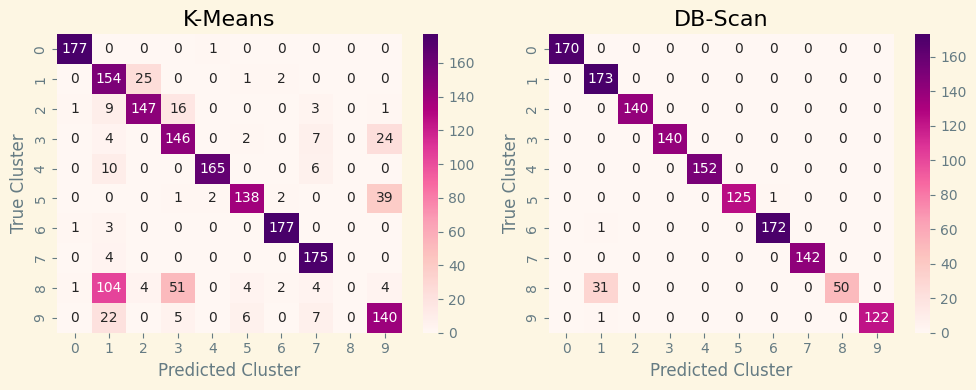

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |        0.98 |     0.99 |      0.99  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |        0.5  |     0.85 |      0.63  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |        0.84 |     0.83 |      0.83  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 3         |        0.67 |     0.8  |      0.73  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 4         |        0.98 |     0.91 |      0.95  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  |

In [22]:
main(X=X_digits, y_true=y_digits.to_numpy(), k=len(np.unique(y_digits)), eps=1.3, scalar_model=MinMaxScaler)

It could be overfitting or misleading if:

    You tuned DBSCAN’s parameters (eps, min_samples) based on label performance, which breaks the unsupervised principle and leads to overfitting to the labels.

    DBSCAN found many tiny or noisy clusters that perfectly matched some small parts of the labeled data — this might look good but doesn’t generalize.

    Some clusters may correspond to very few samples, which artificially boosts metrics.

# **Run Main Classifications**

## Iris

### All Columns

============================== Naive Bayes ==============================
test
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.94      0.84      0.89        19
           2       0.86      0.95      0.90        20

    accuracy                           0.92        50
   macro avg       0.93      0.93      0.93        50
weighted avg       0.92      0.92      0.92        50

train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       0.94      0.94      0.94        31
           2       0.93      0.93      0.93        30

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

============================== KNN n_neighbors=5 ==============================
test
               precision    recall  f1-score   support

          

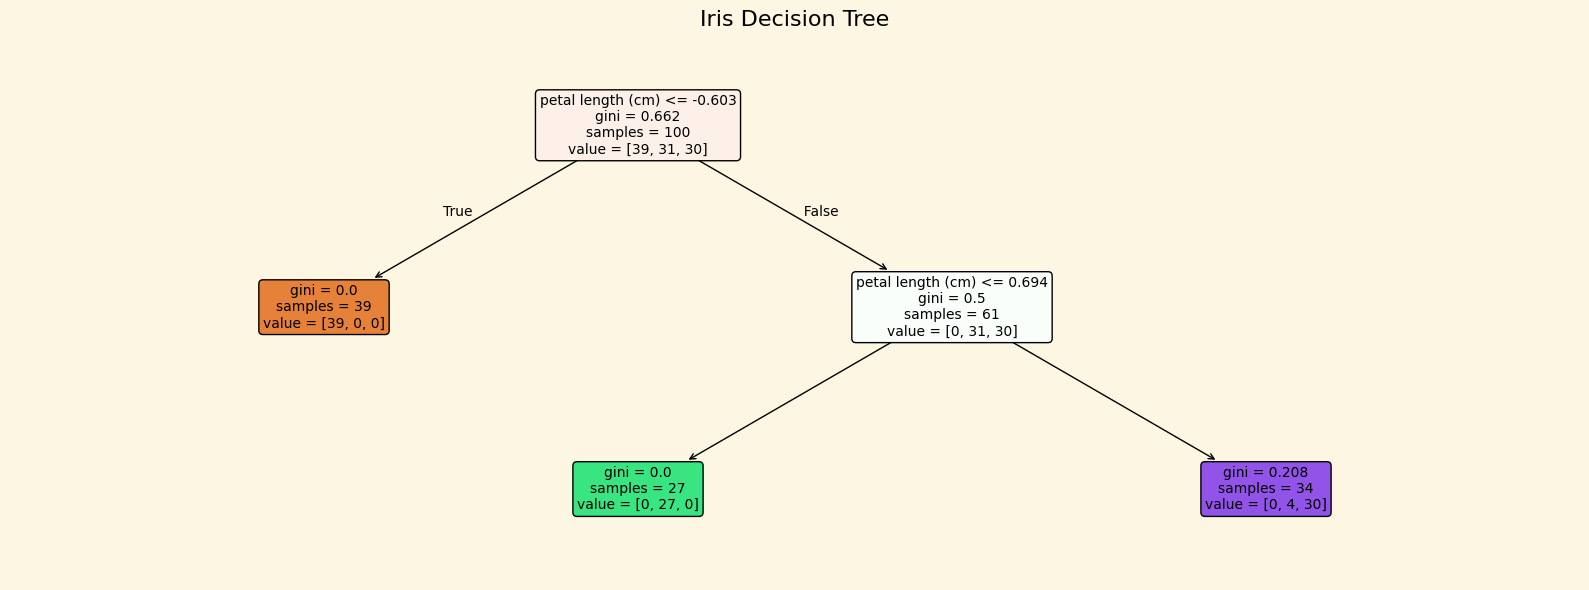

In [23]:
models = [[GaussianNB(), "Naive Bayes"],
          [KNeighborsClassifier(n_neighbors=5), "KNN n_neighbors=5"],
          [DecisionTreeClassifier(max_depth=2), "Decision Tree max_depth=2"]
          ]

dt_model = main_classifications(X_iris.copy(), y_iris, models, StandardScaler, "Iris")

### Selected Columns

============================== Naive Bayes ==============================
test
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.89      0.94      0.91        17
           2       0.94      0.89      0.91        18

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.94      0.97      0.96        33
           2       0.97      0.94      0.95        32

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

============================== KNN n_neighbors=5 ==============================
test
               precision    recall  f1-score   support

          

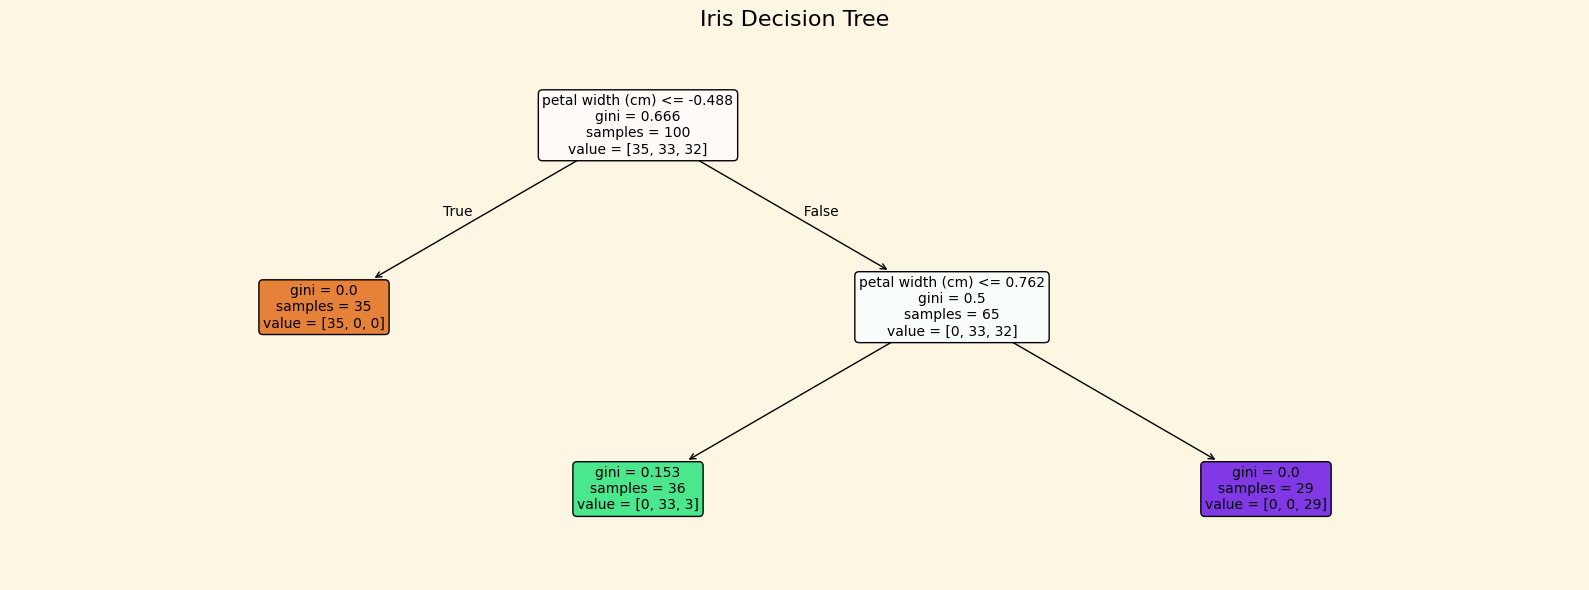

In [24]:
models = [[GaussianNB(), "Naive Bayes"],
          [KNeighborsClassifier(n_neighbors=5), "KNN n_neighbors=5"],
          [DecisionTreeClassifier(max_depth=2), "Decision Tree max_depth=2"]
          ]

dt_model = main_classifications(X_iris.iloc[:, [0, 3]].copy(), y_iris, models, StandardScaler, "Iris")

## Breast Cancer

============================== Naive Bayes ==============================
test
               precision    recall  f1-score   support

           0       0.86      0.84      0.85        58
           1       0.93      0.94      0.93       130

    accuracy                           0.91       188
   macro avg       0.90      0.89      0.89       188
weighted avg       0.91      0.91      0.91       188

train
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       154
           1       0.94      0.96      0.95       227

    accuracy                           0.94       381
   macro avg       0.94      0.93      0.94       381
weighted avg       0.94      0.94      0.94       381

============================== KNN n_neighbors=5 ==============================
test
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        58
           1       0.97      0.98      0.97       130

    accur

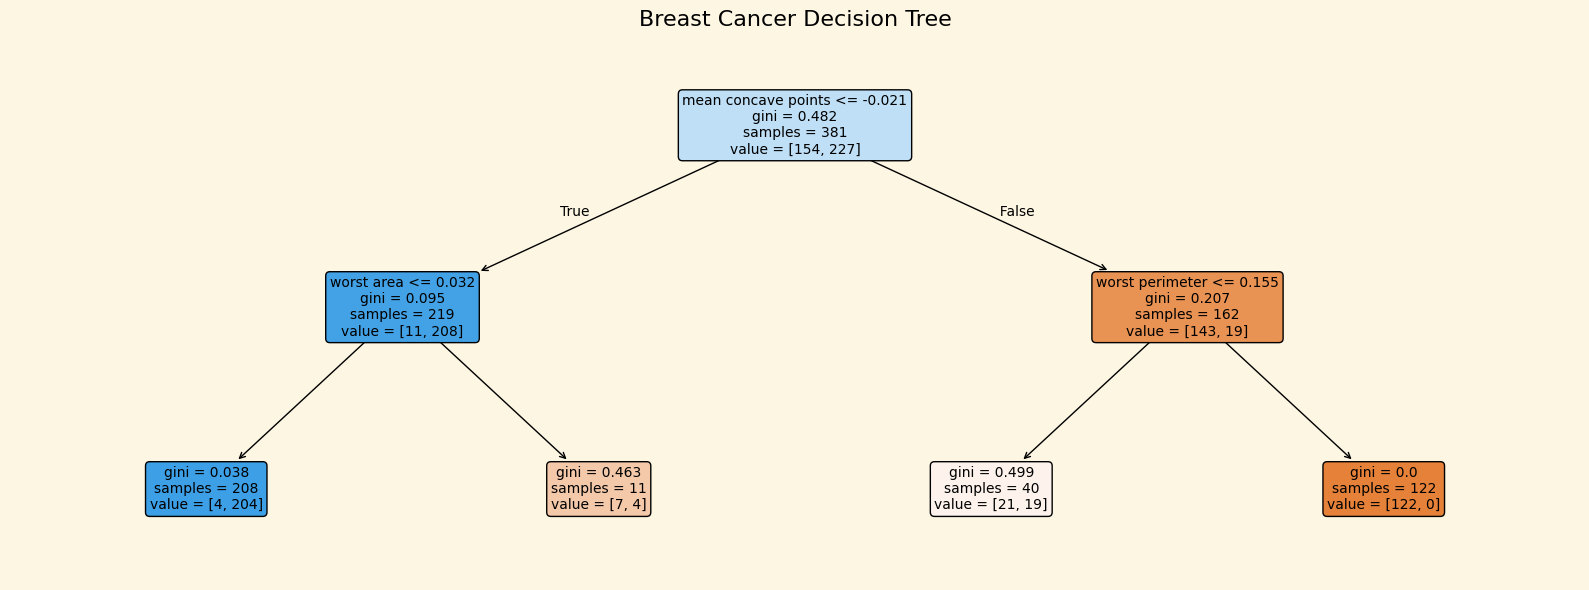

In [25]:
models = [[GaussianNB(), "Naive Bayes"],
          [KNeighborsClassifier(n_neighbors=5), "KNN n_neighbors=5"],
          [LogisticRegression(), "LogisticRegression"],
          [DecisionTreeClassifier(max_depth=2), "Decision Tree max_depth=2"]
          ]

dt_model = main_classifications(X_bc.copy(), y_bc, models, StandardScaler, "Breast Cancer")

## Digits

============================== Naive Bayes ==============================
test
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        62
           1       0.78      0.67      0.72        46
           2       0.93      0.82      0.87        62
           3       0.97      0.84      0.90        67
           4       0.98      0.77      0.86        61
           5       0.75      0.95      0.84        62
           6       0.97      0.98      0.97        57
           7       0.72      0.97      0.83        75
           8       0.59      0.77      0.67        47
           9       0.94      0.53      0.67        55

    accuracy                           0.84       594
   macro avg       0.86      0.83      0.83       594
weighted avg       0.86      0.84      0.84       594

train
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.92      0.65      0.76  

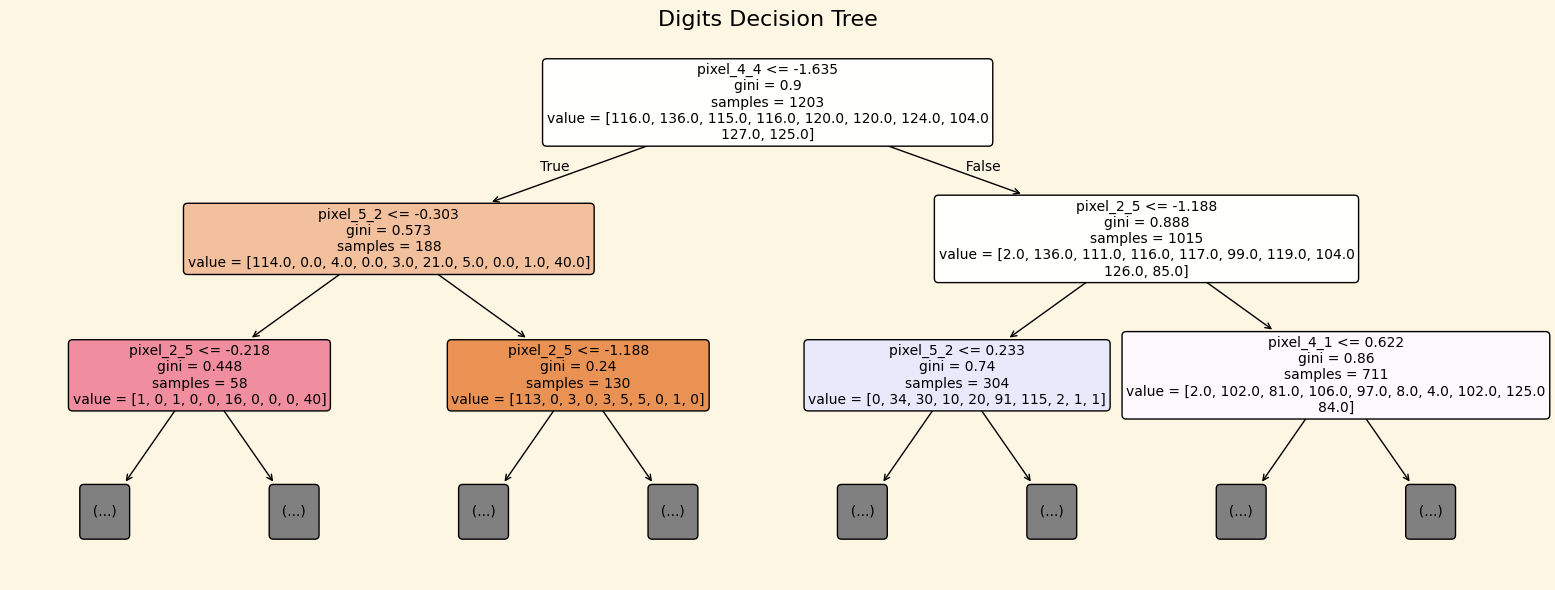

In [26]:
models = [[GaussianNB(), "Naive Bayes"],
          [KNeighborsClassifier(n_neighbors=5), "KNN n_neighbors=5"],
          [DecisionTreeClassifier(max_depth=7), "Decision Tree max_depth=2"]
          ]

dt_model = main_classifications(X_digits.copy(), y_digits, models, StandardScaler, "Digits")